# Distribution Transformer 

In [2]:
import Gmsh: gmsh

In [3]:
gmsh.finalize()
gmsh.initialize()

Error   : Gmsh has not been initialized


# Exercise
TODO: 
 - Define geometry in an image with dimensions & other requirements
 - Define proper mesh densities for each of the nodes
     - Add flexibility to rectangles, not every node should have the same density?

## Section 1: Definition of Geometry and Generation of Mesh 

Set geometrical constants. 

In [4]:
# Enclosure dimensions (enclosure is not centered, the core is)
hencl1 = 65.5e-2;   # Height above the x-axis
hencl2 = -53.5e-2;  # Height below the y-axis
wencl  = 104e-2;    # Width

# Core dimensions
wcore = 84e-2;
hcore = 100e-2;

# Core gap dimensions (left and right are identical)
wgap = 17e-2;
hgap = 76e-2;
mgap = 17e-2;

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Mesh densities
lc1 = 5e-2;      # Enclosure & core outer
lc2 = 1e-2;      # Core inner
lc3 = 1e-2;      # HV windings
lc4 = 1e-2;      # LV windings

Define first function to generate rectangle using 90 degrees corners.

In [5]:
function gmsh_add_rectangle(mid, width, height, lc)
    geo = gmsh.model.geo;
    
    # Corner points
    p1 = geo.addPoint(mid[1] - width / 2, mid[2] - height / 2, 0, lc);
    p2 = geo.addPoint(mid[1] + width / 2, mid[2] - height / 2, 0, lc);
    p3 = geo.addPoint(mid[1] + width / 2, mid[2] + height / 2, 0, lc);
    p4 = geo.addPoint(mid[1] - width / 2, mid[2] + height / 2, 0, lc);
    points = [p1, p2, p3, p4];
    
    # Lines
    l1 = geo.addLine(p1, p2);
    l2 = geo.addLine(p2, p3);
    l3 = geo.addLine(p3, p4);
    l4 = geo.addLine(p4, p1);
    lines = [l1, l2, l3, l4];
    
    # Curve loop
    loop = geo.addCurveLoop(lines);
    
    return loop, lines, points;
end

gmsh_add_rectangle (generic function with 1 method)

Define first function to generate rectangle using rounded corners.

In [6]:
function gmsh_add_rectangle(mid, width, height, lc, radius)
    geo = gmsh.model.geo;
    
    # Corner points
    p1 = geo.addPoint(mid[1] - width / 2 + radius, mid[2] - height / 2, 0, lc);
    p2 = geo.addPoint(mid[1] + width / 2 - radius, mid[2] - height / 2, 0, lc);
    p3 = geo.addPoint(mid[1] + width / 2         , mid[2] - height / 2 + radius, 0, lc);
    p4 = geo.addPoint(mid[1] + width / 2         , mid[2] + height / 2 - radius, 0, lc);
    p5 = geo.addPoint(mid[1] + width / 2 - radius, mid[2] + height / 2, 0, lc);
    p6 = geo.addPoint(mid[1] - width / 2 + radius, mid[2] + height / 2, 0, lc);
    p7 = geo.addPoint(mid[1] - width / 2         , mid[2] + height / 2 - radius, 0, lc);
    p8 = geo.addPoint(mid[1] - width / 2         , mid[2] - height / 2 + radius, 0, lc);
    
    c1 = geo.addPoint(mid[1] - width / 2 + radius, mid[2] - height / 2 + radius, 0, 1);
    c2 = geo.addPoint(mid[1] + width / 2 - radius, mid[2] - height / 2 + radius, 0, 1);
    c3 = geo.addPoint(mid[1] + width / 2 - radius, mid[2] + height / 2 - radius, 0, 1);
    c4 = geo.addPoint(mid[1] - width / 2 + radius, mid[2] + height / 2 - radius, 0, 1);
    points = [p1, p2, p3, p4, p5, p6, p7, p8];
    
    # Lines
    l1 = geo.addLine(p1, p2)
    l2 = geo.addCircleArc(p2, c2, p3)
    l3 = geo.addLine(p3, p4)
    l4 = geo.addCircleArc(p4, c3, p5)
    l5 = geo.addLine(p5, p6)
    l6 = geo.addCircleArc(p6, c4, p7)
    l7 = geo.addLine(p7, p8)
    l8 = geo.addCircleArc(p8, c1, p1)
    lines = [l1, l2, l3, l4, l5, l6, l7, l8]
    
    # Curve loop
    loop = geo.addCurveLoop(lines);
    
    return loop, lines, points;
end

gmsh_add_rectangle (generic function with 2 methods)

Define geometry using above functions.

In [7]:
gmsh.model.add("transformer")
geo = gmsh.model.geo;

## Enclosure
enclosure_lp, enclosure_lines, _ = gmsh_add_rectangle([0, 0.5 * (hencl1 + hencl2)], wencl, hencl1 - hencl2, lc1)

## Core 
core_lp, _, _  = gmsh_add_rectangle([0, 0], wcore, hcore, lc1)     # Core outline
cgap1_lp, _, _ = gmsh_add_rectangle([-mgap, 0], wgap, hgap, lc2, 1.5e-2)   # Gap left
cgap2_lp, _, _ = gmsh_add_rectangle([+mgap, 0], wgap, hgap, lc2, 1.5e-2)   # Gap right

## HV windings
xm = mgap + wgap / 2 + (wcore / 2 - mgap - wgap / 2) / 2;

hv1l_lp, _, _ = gmsh_add_rectangle([-xm - mwhv, 0], wwhv, hwhv, lc3)
hv1r_lp, _, _ = gmsh_add_rectangle([-xm + mwhv, 0], wwhv, hwhv, lc3)
hv2l_lp, _, _ = gmsh_add_rectangle([    - mwhv, 0], wwhv, hwhv, lc3)
hv2r_lp, _, _ = gmsh_add_rectangle([    + mwhv, 0], wwhv, hwhv, lc3)
hv3l_lp, _, _ = gmsh_add_rectangle([+xm - mwhv, 0], wwhv, hwhv, lc3)
hv3r_lp, _, _ = gmsh_add_rectangle([+xm + mwhv, 0], wwhv, hwhv, lc3)

## LV windings
xm = mgap + wgap / 2 + (wcore / 2 - mgap - wgap / 2) / 2;

lv1l_lp, _, _ = gmsh_add_rectangle([-xm - mwlv, 0], wwlv, hwlv, lc4)
lv1r_lp, _, _ = gmsh_add_rectangle([-xm + mwlv, 0], wwlv, hwlv, lc4)
lv2l_lp, _, _ = gmsh_add_rectangle([    - mwlv, 0], wwlv, hwlv, lc4)
lv2r_lp, _, _ = gmsh_add_rectangle([    + mwlv, 0], wwlv, hwlv, lc4)
lv3l_lp, _, _ = gmsh_add_rectangle([+xm - mwlv, 0], wwlv, hwlv, lc4)
lv3r_lp, _, _ = gmsh_add_rectangle([+xm + mwlv, 0], wwlv, hwlv, lc4)

## Surfaces
geo.addPlaneSurface([enclosure_lp, core_lp, hv1l_lp, lv1l_lp, hv3r_lp, lv3r_lp], 1)
geo.addPlaneSurface([core_lp, cgap1_lp, cgap2_lp], 2)
geo.addPlaneSurface([cgap1_lp, hv1r_lp, lv1r_lp, hv2l_lp, lv2l_lp], 3)
geo.addPlaneSurface([cgap2_lp, hv2r_lp, lv2r_lp, hv3l_lp, lv3l_lp], 4)

geo.addPlaneSurface([hv1l_lp], 5)
geo.addPlaneSurface([hv1r_lp], 6)
geo.addPlaneSurface([hv2l_lp], 7)
geo.addPlaneSurface([hv2r_lp], 8)
geo.addPlaneSurface([hv3l_lp], 9)
geo.addPlaneSurface([hv3r_lp], 10)

geo.addPlaneSurface([lv1l_lp], 11)
geo.addPlaneSurface([lv1r_lp], 12)
geo.addPlaneSurface([lv2l_lp], 13)
geo.addPlaneSurface([lv2r_lp], 14)
geo.addPlaneSurface([lv3l_lp], 15)
geo.addPlaneSurface([lv3r_lp], 16)

geo.synchronize()

## Physical Groups
geo.addPhysicalGroup(2, [1, 3, 4], 1)   # Transformer oil
geo.addPhysicalGroup(2, [2], 2)         # Core
geo.addPhysicalGroup(2, [5], 3)         # HV winding phase 1 left
geo.addPhysicalGroup(2, [6], 4)         # HV winding phase 1 right
geo.addPhysicalGroup(2, [7], 5)         # HV winding phase 2 left
geo.addPhysicalGroup(2, [8], 6)         # HV winding phase 2 right
geo.addPhysicalGroup(2, [9], 7)         # HV winding phase 3 left
geo.addPhysicalGroup(2, [10], 8)        # HV winding phase 3 right

geo.addPhysicalGroup(2, [11], 9)        # LV winding phase 1 left
geo.addPhysicalGroup(2, [12], 10)       # LV winding phase 1 right
geo.addPhysicalGroup(2, [13], 11)       # LV winding phase 2 left
geo.addPhysicalGroup(2, [14], 12)       # LV winding phase 2 right
geo.addPhysicalGroup(2, [15], 13)       # LV winding phase 3 left
geo.addPhysicalGroup(2, [16], 14)       # LV winding phase 3 right

geo.addPhysicalGroup(2, [5, 6, 7, 8, 9, 10], 15)      # HV windings
geo.addPhysicalGroup(2, [11, 12, 13, 14, 15, 16], 16) # LV windings

geo.addPhysicalGroup(1, enclosure_lines, 1)  # Enclosure boundary

gmsh.model.setPhysicalName(2, 1, "Oil")
gmsh.model.setPhysicalName(2, 2, "Core")
gmsh.model.setPhysicalName(2, 15, "HV windings")
gmsh.model.setPhysicalName(2, 16, "LV windings")

gmsh.model.setPhysicalName(1, 1, "Enclosure")

# Generate Mesh
geo.synchronize()
gmsh.model.mesh.generate(2)

gmsh.write("exercises/transformer_stedin.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Circle)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Circle)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Circle)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Circle)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Circle)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Circle)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Circle)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%] Meshing cur

In [8]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.10.2
License       : GNU General Public License
Build OS      : MacOSX-sdk
Build date    : 19700101
Build host    : amdci7
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack MathEx[contrib] Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.3.8
OCC version   : 7.6.2
Packaged by   : root
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


## Section 2: Visualization of the Geometry and Mesh using Makie 

In [9]:
using CairoMakie
using GeometryBasics
using Colors, ColorSchemes

CairoMakie.activate!(type = "svg")

In [10]:
function get_cell_mesh(cell_val)
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nNode = length(node_ids)

    eType, eTag, eConn = gmsh.model.mesh.getElements(2);
    nEl = length(eTag[1])
    
    points   = zeros(Point{2, Float64}, nEl * 3);   # Array of vertex coordinates (x,y)
    trif     = zeros(TriangleFace{Int}, nEl);      # Array of triangular faces (n1, n2, n3)
    node_val = zeros(Float64, nEl * 3);

    for e = 1:nEl
        n1idx = 3 * (e - 1) + 1; n1 = eConn[1][n1idx];
        n2idx = 3 * (e - 1) + 2; n2 = eConn[1][n2idx];
        n3idx = 3 * (e - 1) + 3; n3 = eConn[1][n3idx];

        points[n1idx] = Point{2}(node_coord[3*(n1-1) + 1], node_coord[3*(n1-1) + 2])
        points[n2idx] = Point{2}(node_coord[3*(n2-1) + 1], node_coord[3*(n2-1) + 2])
        points[n3idx] = Point{2}(node_coord[3*(n3-1) + 1], node_coord[3*(n3-1) + 2])
        
        node_val[n1idx] = cell_val[e];
        node_val[n2idx] = cell_val[e];
        node_val[n3idx] = cell_val[e];

        trif[e] = (n1idx, n2idx, n3idx);
    end

    msh = GeometryBasics.Mesh(points, trif);
    
    return msh, node_val
end

get_cell_mesh (generic function with 1 method)

In [13]:
gmsh.open("exercises/transformer_stedin.msh")

Info    : Reading 'exercises/transformer_stedin.msh'...
Info    : 168 entities
Info    : 8004 nodes
Info    : 16006 elements
Info    : Done reading 'exercises/transformer_stedin.msh'


In [14]:
#..4/12 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/12 Create groups of elements for the subdomains
#..for loop that creates a vector describing which physical group an element belongs to
ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 1)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 2)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 15)[1]
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(2, 16)[1]

e_group = zeros(1,nelements)
for element_id in 1:nelements
    node1_id = element_connectivity[1][3*(element_id-1)+1]
    node2_id = element_connectivity[1][3*(element_id-1)+2]
    node3_id = element_connectivity[1][3*(element_id-1)+3]
    G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1])+sum(node3_id.== ngroup1[1]) # Transformer oil
    G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1])+sum(node3_id.== ngroup2[1]) # Core
    G3 = sum(node1_id.== ngroup3)+sum(node2_id.== ngroup3)+sum(node3_id.== ngroup3) # HV windings
    G4 = sum(node1_id.== ngroup4)+sum(node2_id.== ngroup4)+sum(node3_id.== ngroup4) # LV windings
    if G1 == 3
        e_group[element_id] = 1;
    elseif G2 == 3
        e_group[element_id] = 2;
    elseif G3 == 3
        e_group[element_id] = 3;
    elseif G4 == 3
        e_group[element_id] = 4;
    end
end

## Geometry

In [15]:
cell_val = e_group;
msh, colors = get_cell_mesh(cell_val);

cmap = ColorScheme([RGB(0.788, 0.788, 0.784), RGB(0.592, 0.180, 0.996), RGB(1.0, 0.631, 0.216), RGB(0.671, 1.0, 0.224)])

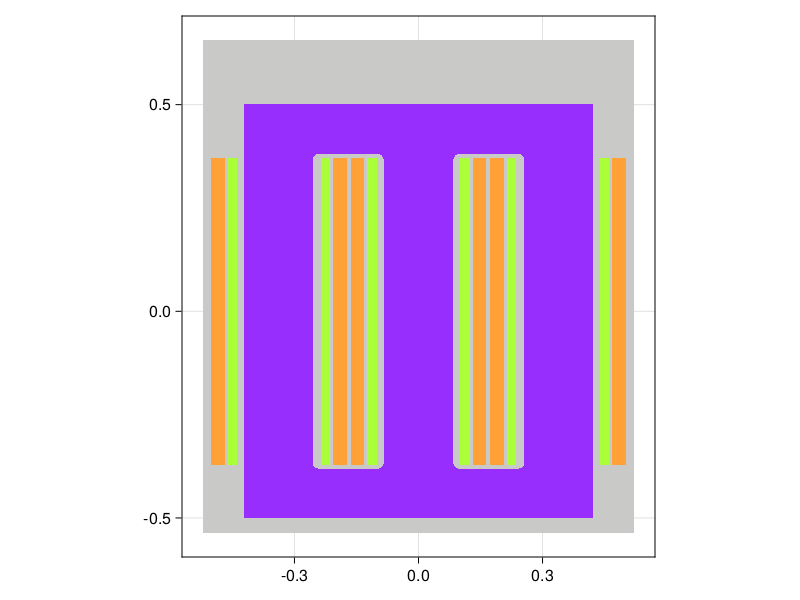

In [16]:
f, ax, pl = mesh(msh, color = colors, colormap = cmap, shading = false)
ax.aspect = DataAspect()
current_figure()

In [17]:
save("exercises/transformer_stedin.png", f)

CairoMakie.Screen{IMAGE}


![Geometry: Distribution Transformer Stedin](exercises/transformer_stedin.png)

## Mesh

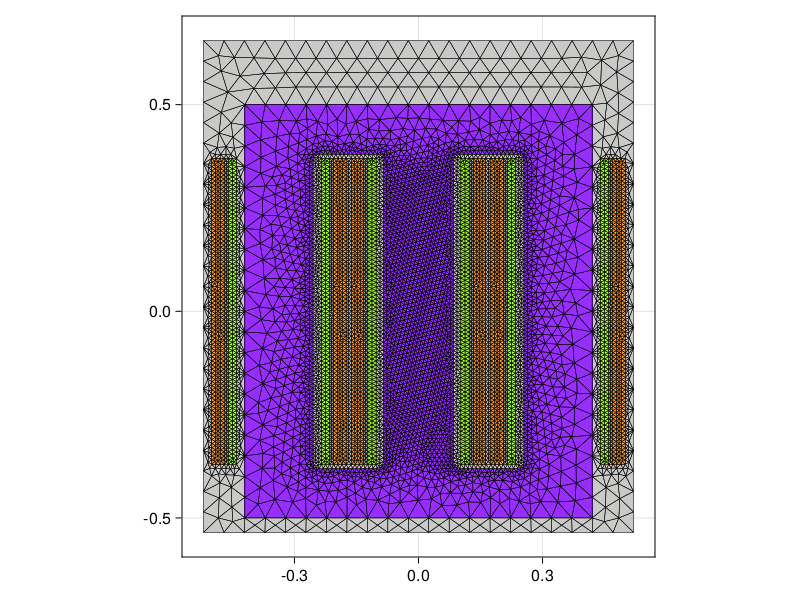

In [18]:
f, ax, pl = mesh(msh, color = colors, colormap = cmap, shading = false)
wireframe!(ax, msh, color=(:black), linewidth=0.5, transparency=false)
ax.aspect = DataAspect()
current_figure()

In [19]:
save("exercises/transformer_stedin_mesh.png", f)

CairoMakie.Screen{IMAGE}


![Mesh: Distribution Transformer Stedin](exercises/transformer_stedin_mesh.png)